In [77]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('datasets/FilteredData.csv')

In [3]:
# for more info look at HAFLAGA_fixed_menstruation.ipynb
def HAFLAGA_fixed_mestruation_ClientID_list(data):
    df = data[['ClientID','CycleNumber','LengthofCycle']].copy()
    df['shift_1'] = df['LengthofCycle'].shift(1)
    df['shift_2'] = df['LengthofCycle'].shift(2)
    mask = df['CycleNumber'] < 3
    df.loc[mask, ['shift_1', 'shift_2']] = np.nan
    df['fixing'] = 0
    mask = (df['LengthofCycle'] == df['shift_1']) & (df['LengthofCycle'] == df['shift_2'])
    df.loc[mask, ['fixing']] = 1
    fixed_haflaga_df = df[df['fixing']==1]
    return fixed_haflaga_df['ClientID'].unique()

to_remove_list = HAFLAGA_fixed_mestruation_ClientID_list(data)
data = data[~data["ClientID"].isin(to_remove_list)]
data.reset_index(drop=True, inplace=True)

In [4]:
df = data[['ClientID','CycleNumber','LengthofCycle']].copy()
df.loc[:, 'LengthofCycle'] = df['LengthofCycle'] + 1
df['Semi_Fixed'] = 0
df['min'] = 0
df['max'] = 0

# Indicate when there is a Semi-Fixed mestruation
for index, row in df.iterrows():
    if row['CycleNumber'] == 1 or (df.at[index-1, 'Semi_Fixed'] == 1 and (row['LengthofCycle'] > df.at[index-1, 'max'] or row['LengthofCycle'] < df.at[index-1, 'min'])):
        df.at[index, 'Semi_Fixed'] = 0
        df.at[index, 'min'] = row['LengthofCycle']
        df.at[index, 'max'] = row['LengthofCycle']
    elif row['CycleNumber'] == 2 or (df.at[index-1, 'Semi_Fixed'] == 0 and df.at[index-2, 'Semi_Fixed'] == 1 and row['CycleNumber'] > 2):
        df.at[index, 'Semi_Fixed'] = 0
        df.at[index, 'min'] = min(row['LengthofCycle'], df.at[index-1, 'min'])
        df.at[index, 'max'] = max(row['LengthofCycle'], df.at[index-1, 'max'])
    elif (df.at[index-1, 'Semi_Fixed'] == 0 and df.at[index-2, 'Semi_Fixed'] == 0) or (df.at[index-1, 'Semi_Fixed'] == 1 and df.at[index-1, 'min'] <= row['LengthofCycle'] <= df.at[index-1, 'max']):
        df.at[index, 'Semi_Fixed'] = 1
        df.at[index, 'min'] = min(row['LengthofCycle'], df.at[index-1, 'min'])
        df.at[index, 'max'] = max(row['LengthofCycle'], df.at[index-1, 'max'])

# Assign states
initial_value = 'Not set yet'
df['State'] = initial_value

df.loc[(df['Semi_Fixed'] == 1) & (df['max'] < 29),'State'] = 'S31'
df.loc[(df['Semi_Fixed'] == 1) & (df['min'] > 31),'State'] = 'S33'
df.loc[(df['Semi_Fixed'] == 1) & (df['State'] == initial_value),'State'] = 'S32'

for index, row in df.iterrows():
    if row['CycleNumber'] == 1 or (df.at[index-1,'State'].startswith('S3') and row['State'] == initial_value):
        if row['max'] < 29:
            df.at[index, 'State'] = 'S11'
        elif row['min'] > 31:
            df.at[index, 'State'] = 'S13'
        else:
            df.at[index, 'State'] = 'S12'
    elif row['State'] == initial_value:
        if row['max'] < 29:
            df.at[index, 'State'] = 'S21'
        elif row['min'] > 31:
            df.at[index, 'State'] = 'S23'
        else:
            df.at[index, 'State'] = 'S22'  


In [5]:
# An example
df[df['ClientID']=='nfp8122']

,ClientID,CycleNumber,LengthofCycle,Semi_Fixed,min,max,State
0,nfp8122,1,30,0,30,30,S12
1,nfp8122,2,28,0,28,30,S22
2,nfp8122,3,30,1,28,30,S32
3,nfp8122,4,28,1,28,30,S32
4,nfp8122,5,29,1,28,30,S32
5,nfp8122,6,27,0,27,27,S11
6,nfp8122,7,30,0,27,30,S22
7,nfp8122,8,25,1,25,30,S32
8,nfp8122,9,29,1,25,30,S32
9,nfp8122,10,29,1,25,30,S32


In [86]:
def count_state_transitions(df, state_from, state_to):
    transitions_count = ((df['State'].shift() == state_from) & (df['State'] == state_to) & (df['ClientID'].shift() == df['ClientID'])).sum()
    return transitions_count

def transitions_dataframe_and_matrix(df):
    states = ['S11', 'S12', 'S13', 'S21', 'S22', 'S23', 'S31', 'S32', 'S33']
    transitions = []

    for state_from in states:
        for state_to in states:
                transitions_count = count_state_transitions(df, state_from, state_to)
                if transitions_count != 0:
                    transitions.append({'State_From': state_from, 'State_To': state_to, 'Transitions_Count': transitions_count})

    transitions_df = pd.DataFrame(transitions)
    transitions_df['State_Total_Transitions_Count'] = transitions_df.groupby('State_From')['Transitions_Count'].transform('sum')
    transitions_df['Proportion'] = transitions_df['Transitions_Count'] / transitions_df['State_Total_Transitions_Count']
    
    transition_matrix = pd.pivot_table(transitions_df, values='Proportion', index='State_From', columns='State_To', fill_value=0)
    
    transition_matrix_transposed = transition_matrix.transpose()
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix_transposed)
    stationary_index = np.where(np.isclose(eigenvalues, 1))[0]
    stationary_distribution = np.real(eigenvectors[:, stationary_index].flatten())
    stationary_distribution = stationary_distribution / np.sum(stationary_distribution)
    
    
    return transitions_df, transition_matrix, stationary_distribution


In [81]:
transitions_df, transition_matrix, stationary_distribution = transitions_dataframe_and_matrix(df)
transitions_df

,State_From,State_To,Transitions_Count,State_Total_Transitions_Count,Proportion
0,S11,S21,48,90,0.533333
1,S11,S22,42,90,0.466667
2,S12,S22,76,76,1.000000
3,S13,S22,54,96,0.562500
4,S13,S23,42,96,0.437500
5,S21,S31,27,47,0.574468
6,S21,S32,20,47,0.425532
7,S22,S32,161,161,1.000000
8,S23,S32,9,40,0.225000
9,S23,S33,31,40,0.775000


In [82]:
transition_matrix

State_To,S11,S12,S13,S21,S22,S23,S31,S32,S33
State_From,,,,,,,,,
S11,0.000000,0.000000,0.000000,0.533333,0.466667,0.0000,0.000000,0.000000,0.000000
S12,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000
S13,0.000000,0.000000,0.000000,0.000000,0.562500,0.4375,0.000000,0.000000,0.000000
S21,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.574468,0.425532,0.000000
S22,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,0.000000
S23,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.225000,0.775000
S31,0.295455,0.272727,0.000000,0.000000,0.000000,0.0000,0.431818,0.000000,0.000000
S32,0.117296,0.051690,0.089463,0.000000,0.000000,0.0000,0.000000,0.741551,0.000000
S33,0.015152,0.166667,0.242424,0.000000,0.000000,0.0000,0.000000,0.000000,0.575758


In [83]:
stationary_distribution

array([0.07655605, 0.04731715, 0.06019421, 0.04082989, 0.11690255,
       0.02633497, 0.04128163, 0.54247521, 0.04810834])

$\pi_{S_{31}} + \pi_{S_{33}}$

In [10]:
# Semi-Fixed states, without the need for abstinence at the 30'th day and the monthly date.
stationary_distribution[-3] + stationary_distribution[-1] 

0.08938996858975995

Hypothesis Testing

In [23]:
df.groupby('State')['ClientID'].nunique().loc[['S31','S32','S33']]

State
S31    16
S32    90
S33    24
Name: ClientID, dtype: int64

In [37]:
clients_S31 = df[df['State'].isin(['S31'])]['ClientID'].unique()
clients_S32 = df[df['State'].isin(['S32'])]['ClientID'].unique()
clients_S33 = df[df['State'].isin(['S33'])]['ClientID'].unique()
len(clients_S31), len(clients_S32), len(clients_S33)

(16, 90, 24)

In [42]:
group_S31 = [x for x in clients_S31]
group_S32 = [x for x in clients_S32 if (x not in clients_S33 and x not in clients_S31)]
group_S33 = [x for x in clients_S33]
(len(group_S31), len(group_S32), len(group_S33))

(16, 58, 24)

In [44]:
group_S31_lengths = df[df['ClientID'].isin(group_S31)]['LengthofCycle']
group_S32_lengths = df[df['ClientID'].isin(group_S32)]['LengthofCycle']
group_S33_lengths = df[df['ClientID'].isin(group_S33)]['LengthofCycle']

len(group_S31_lengths), len(group_S32_lengths), len(group_S33_lengths)


(243, 674, 304)

In [49]:
group_S31_lengths.reset_index(drop=True, inplace=True)
group_S32_lengths.reset_index(drop=True, inplace=True)
group_S33_lengths.reset_index(drop=True, inplace=True)


In [70]:
group_S31_lengths.mean(), group_S32_lengths.mean(), group_S33_lengths.mean()

(27.551440329218106, 30.130563798219583, 33.848684210526315)

In [63]:
# Create a dictionary of normality test results
normality_results = {
    'Group': ['group_S31', 'group_S32', 'group_S33'],
    'Test': [],
    'Statistic': [],
    'P-value': [],
    'Normal': []
}

# Significance level for determining normality
significance_level = 0.05

# Perform normality tests for each group and store the results in the dictionary
for group_name, group_data in [('group_S31', group_S31_lengths), ('group_S32', group_S32_lengths), ('group_S33', group_S33_lengths)]:
    statistic, p_value = stats.shapiro(group_data)
    normality_results['Test'].append('Shapiro-Wilk')
    # statistic, p_value = stats.kstest(group_data, 'norm')
    # normality_results['Test'].append('Kolmogorov-Smirnov')
    normality_results['Statistic'].append(statistic)
    normality_results['P-value'].append(p_value)
    normality_results['Normal'].append(p_value > significance_level)

# Create a dataframe from the results dictionary
normality_df = pd.DataFrame(normality_results)
normality_df

,Group,Test,Statistic,P-value,Normal
0,group_S31,Shapiro-Wilk,0.936108,8.800110e-09,False
1,group_S32,Shapiro-Wilk,0.938818,5.118325e-16,False
2,group_S33,Shapiro-Wilk,0.943605,2.216858e-09,False


In [65]:
# Perform Levene's test for homogeneity of variances
statistic, p_value = stats.levene(group_S31_lengths, group_S32_lengths, group_S33_lengths)

# Print the results
print("Levene's test for homogeneity of variances:")
print("Statistic:", statistic)
print("P-value:", p_value)

significance_level = 0.05
if p_value > significance_level:
    conclusion = "There is no significant difference in variances across the groups. The assumption of homogeneity of variances is met."
else:
    conclusion = "There is a significant difference in variances across the groups. The assumption of homogeneity of variances is violated."

print("Conclusion:", conclusion)

Levene's test for homogeneity of variances:
Statistic: 40.475138510604495
P-value: 9.579651360188648e-18
Conclusion: There is a significant difference in variances across the groups. The assumption of homogeneity of variances is violated.


In [66]:
# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(group_S31_lengths, group_S32_lengths, group_S33_lengths)

# Print the results
print("Kruskal-Wallis test:")
print("Statistic:", statistic)
print("P-value:", p_value)

# Check the conclusion
significance_level = 0.05
if p_value > significance_level:
    conclusion = "There is no significant difference in the mean ranks across the groups."
else:
    conclusion = "There is a significant difference in the mean ranks across the groups."

print("Conclusion:", conclusion)


Kruskal-Wallis test:
Statistic: 386.2512381800058
P-value: 1.3384720758600194e-84
Conclusion: There is a significant difference in the mean ranks across the groups.


In [69]:
from itertools import combinations

# List of group names and data
groups = [('S31', group_S31_lengths), ('S32', group_S32_lengths), ('S33', group_S33_lengths)]

# Perform pairwise comparisons using Dunn's test with Bonferroni correction
for group1, group2 in combinations(groups, 2):
    group1_name, group1_data = group1
    group2_name, group2_data = group2
    
    statistic, p_value = stats.kruskal(group1_data, group2_data)
    adjusted_p_value = p_value * len(groups) * (len(groups) - 1) / 2  # Bonferroni correction
    
    if adjusted_p_value < significance_level:
        conclusion = f"There is a significant difference between {group1_name} and {group2_name}."
    else:
        conclusion = f"There is no significant difference between {group1_name} and {group2_name}."
    
    print("Pair:", group1_name, "-", group2_name)
    print("Statistic:", statistic)
    print("P-value:", adjusted_p_value)
    print("Conclusion:", conclusion)
    print()


Pair: S31 - S32
Statistic: 146.87022755456852
P-value: 2.5131676835687667e-33
Conclusion: There is a significant difference between S31 and S32.

Pair: S31 - S33
Statistic: 306.19379610668705
P-value: 4.420975774566306e-68
Conclusion: There is a significant difference between S31 and S33.

Pair: S32 - S33
Statistic: 177.43176740557735
P-value: 5.288259674743711e-40
Conclusion: There is a significant difference between S32 and S33.



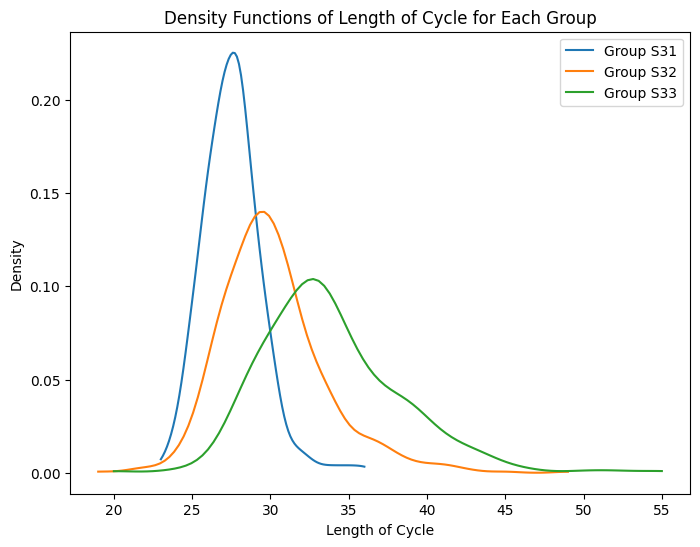

In [79]:
# Plot the density functions
plt.figure(figsize=(8, 6))

# Group S31
density_S31 = stats.gaussian_kde(group_S31_lengths)
x_S31 = np.linspace(min(group_S31_lengths), max(group_S31_lengths), 100)
plt.plot(x_S31, density_S31(x_S31), label='Group S31')

# Group S32
density_S32 = stats.gaussian_kde(group_S32_lengths)
x_S32 = np.linspace(min(group_S32_lengths), max(group_S32_lengths), 100)
plt.plot(x_S32, density_S32(x_S32), label='Group S32')

# Group S33
density_S33 = stats.gaussian_kde(group_S33_lengths)
x_S33 = np.linspace(min(group_S33_lengths), max(group_S33_lengths), 100)
plt.plot(x_S33, density_S33(x_S33), label='Group S33')

# Set plot properties
plt.xlabel('Length of Cycle')
plt.ylabel('Density')
plt.title('Density Functions of Length of Cycle for Each Group')
plt.legend()

# Show the plot
plt.show()

In [33]:
# clients_S31_S32 = df[df['ClientID'].isin(df.loc[df['State'] == 'S31', 'ClientID']) & df['ClientID'].isin(df.loc[df['State'] == 'S32', 'ClientID'])]['ClientID'].unique()
# clients_S32_S33 = df[df['ClientID'].isin(df.loc[df['State'] == 'S32', 'ClientID']) & df['ClientID'].isin(df.loc[df['State'] == 'S33', 'ClientID'])]['ClientID'].unique()
# clients_S31_S33 = df[df['ClientID'].isin(df.loc[df['State'] == 'S31', 'ClientID']) & df['ClientID'].isin(df.loc[df['State'] == 'S33', 'ClientID'])]['ClientID'].unique()
# (len(clients_S31_S32), len(clients_S32_S33), len(clients_S31_S33))

(14, 18, 0)

In [88]:
group_S31_df = df[df['ClientID'].isin(group_S31)].copy()
group_S32_df = df[df['ClientID'].isin(group_S32)].copy()
group_S33_df = df[df['ClientID'].isin(group_S33)].copy()

group_S31_df.reset_index(drop=True, inplace=True)
group_S32_df.reset_index(drop=True, inplace=True)
group_S33_df.reset_index(drop=True, inplace=True)

In [89]:
group_S31_transitions_df, group_S31_transition_matrix, group_S31_stationary_distribution = transitions_dataframe_and_matrix(group_S31_df)
group_S32_transitions_df, group_S32_transition_matrix, group_S32_stationary_distribution = transitions_dataframe_and_matrix(group_S32_df)
group_S33_transitions_df, group_S33_transition_matrix, group_S33_stationary_distribution = transitions_dataframe_and_matrix(group_S33_df)

In [91]:
group_S31_transition_matrix

State_To,S11,S12,S13,S21,S22,S31,S32
State_From,,,,,,,
S11,0.000000,0.000000,0.000000,0.825,0.175,0.000000,0.000000
S12,0.000000,0.000000,0.000000,0.000,1.000,0.000000,0.000000
S13,0.000000,0.000000,0.000000,0.000,1.000,0.000000,0.000000
S21,0.000000,0.000000,0.000000,0.000,0.000,0.843750,0.156250
S22,0.000000,0.000000,0.000000,0.000,0.000,0.000000,1.000000
S31,0.295455,0.272727,0.000000,0.000,0.000,0.431818,0.000000
S32,0.264706,0.029412,0.029412,0.000,0.000,0.000000,0.676471


In [92]:
group_S31_stationary_distribution

array([0.15180762, 0.06148472, 0.010762  , 0.12524128, 0.09881305,
       0.18598331, 0.36590802])

$[\pi_{S_{31}}]_6 = 18.6\%$

In [93]:
group_S31_stationary_distribution[-2]

0.18598330748738326

In [94]:
group_S33_transition_matrix

State_To,S11,S12,S13,S22,S23,S32,S33
State_From,,,,,,,
S11,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000
S12,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000
S13,0.000000,0.000000,0.000000,0.214286,0.785714,0.00000,0.000000
S22,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
S23,0.000000,0.000000,0.000000,0.000000,0.000000,0.03125,0.968750
S32,0.096386,0.048193,0.120482,0.000000,0.000000,0.73494,0.000000
S33,0.015152,0.166667,0.242424,0.000000,0.000000,0.00000,0.575758


In [95]:
group_S33_stationary_distribution

array([0.04567253, 0.05003966, 0.09530495, 0.11613468, 0.07488246,
       0.44697294, 0.17099277])

$[\pi_{S_{33}}]_7 = 17.1\%$

In [96]:
group_S33_stationary_distribution[-1]

0.1709927700737576